In [ ]:
# ============================================
# 0. Imports
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb



In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

# For nice plots
plt.style.use("seaborn-v0_8")

In [ ]:
# ============================================
# 1. Load data & basic cleaning
# ============================================
df = pd.read_excel('/content/final_Cleaned.xlsx', sheet_name=0)

# Drop irrelevant columns by index (same as your original logic)
cols_to_drop_indices = [0, 1, 2, 3, 25, 27, 28, 37, 38, 39, 40, 41, 42, 43]
cols_to_drop_names = df.columns[cols_to_drop_indices]
df = df.drop(columns=cols_to_drop_names)

print("Columns dropped based on index:")
print(cols_to_drop_names.tolist())
print("Shape after dropping columns:", df.shape)

# Remove duplicate rows
dup_count = df.duplicated().sum()
print(f"Number of duplicate rows before removal: {dup_count}")
df = df.drop_duplicates()
print("Number of duplicate rows after removal:", df.duplicated().sum())


Columns dropped based on index:
['Steel', 'Brand', 'Supplier', 'Code', 'Laboratory or commercial work', 'Distance from Head End and/or Position Across Width (m,mm)', 'Orientation', 'n Value', 'r Value\n10%', 'r bar\nValue', 'Drilled/Punched Hole Diameter (mm)', 'Punch Diameter (mm)', 'Punch Shape', 'Expansion (%)']
Shape after dropping columns: (934, 30)
Number of duplicate rows before removal: 3
Number of duplicate rows after removal: 0


In [ ]:
# ============================================
# 2. Column name cleaning (for all models)
# ============================================
def clean_col_name(col: str) -> str:
    return (
        col.replace(' ', '_')
           .replace('\n', '')
           .replace('(', '')
           .replace(')', '')
           .replace('%', '')
           .replace('°C', '')
    )

df.columns = [clean_col_name(c) for c in df.columns]

# Adjust these if your names differ
ts_col_name = 'TSN/mm2'    # from 'TS\n(N/mm2)' after cleaning
ps_col_name = '0.2_PSN/mm2'         # <-- change if your PS column has a different cleaned name
ratio_col_name = 'PS/TS'    # from 'PS/TS' after cleaning (if present)

print("\nColumns after cleaning:")
print(df.columns.tolist())



Columns after cleaning:
['C', 'Si', 'Mn', 'P', 'S', 'Cr', 'Mo', 'Ni', 'Al', 'B', 'Ca', 'Cu', 'N', 'Nb', 'Ti', 'V', 'CEV', 'Reheat_temperature_', 'Finishing_temperature_', 'Intermediate_temperature_', 'Coiling_temperature_', 'Gaugemm', '0.2_PSN/mm2', 'TSN/mm2', 'PS/TS', 'El.Ag', 'Total_El.A5', 'Total_El.A50', 'Total_El.A80', 'Total_El.']


In [ ]:
# ============================================
# 3. Common preprocessing pipeline
#    Order: KNNImputer -> QuantileTransform -> StandardScaler
#    (fitted only on training data inside each model pipeline)
# ============================================
preprocessor = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('quantile', QuantileTransformer(output_distribution='normal', random_state=42)),
    ('scaler', StandardScaler())
])

In [ ]:
# ============================================
# 4. Helper function to train & evaluate for a given target
#    - target_col: column to predict (PS or TS)
#    - exclude_cols: list of columns to exclude from features (e.g. TS, PS, PS/TS)
# ============================================
def run_full_experiment(df, target_col, exclude_cols, title_prefix=""):
    print(f"\n{'='*60}")
    print(f"{title_prefix} : Target = {target_col}")
    print(f"Excluding features: {exclude_cols}")
    print(f"{'='*60}\n")

    # 4.1 Prepare X and y
    # We still need to drop rows where TARGET is missing;
    # models cannot be trained with NaN labels.
    df_local = df.copy()
    df_local = df_local.dropna(subset=[target_col])

    y = df_local[target_col]
    X = df_local.drop(columns=[target_col] + exclude_cols, errors='ignore')

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    # 4.2 Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

    # 4.3 Define models
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=1.0, max_iter=10000, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'RandomForest': RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            random_state=42,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1
        ),
        'LightGBM': lgb.LGBMRegressor(
            random_state=42,
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=31,
            n_jobs=-1
        ),
        'CatBoost': CatBoostRegressor(
            random_seed=42,
            iterations=300,
            learning_rate=0.05,
            depth=6,
            verbose=0
        )
    }

    # Wrap each model with the common preprocessing pipeline
    pipelines = {
        name: Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', model)
        ])
        for name, model in models.items()
    }

    # 4.4 Train & evaluate base models
    results = []
    y_pred_dict = {}

    for name, pipe in pipelines.items():
        print(f"\nTraining base model: {name}")
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_pred_dict[name] = y_pred

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"{name} - R2: {r2:.4f}, MAE: {mae:.4f}")
        results.append({
            'Model': name,
            'R2': r2,
            'MAE': mae
        })

    results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
    print(f"\n=== {title_prefix} - Base Model Performance (Test Set) ===")
    print(results_df)

    # 4.5 Plots: Actual vs Predicted for all base models
    for name, y_pred in y_pred_dict.items():
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        # 45-degree reference line
        y_min = min(y_test.min(), y_pred.min())
        y_max = max(y_test.max(), y_pred.max())
        plt.plot([y_min, y_max], [y_min, y_max])
        plt.xlabel(f"Actual {target_col}")
        plt.ylabel(f"Predicted {target_col}")
        plt.title(f"{title_prefix} - Actual vs Predicted ({name})")
        plt.tight_layout()
        plt.show()

    # 4.6 Model comparison bar chart (R²)
    plt.figure(figsize=(8, 5))
    plt.bar(results_df['Model'], results_df['R2'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("R² (Test)")
    plt.title(f"{title_prefix} - Model Comparison (R² on Test Set)")
    plt.tight_layout()
    plt.show()

    # 4.7 Hyperparameter tuning for tree-based + Lasso
    # ---- Lasso ----
    lasso_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', Lasso(max_iter=10000, random_state=42))
    ])
    lasso_param_grid = {
        'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
    print(f"\nStarting GridSearchCV for Lasso ({title_prefix})...")
    grid_lasso = GridSearchCV(
        estimator=lasso_pipe,
        param_grid=lasso_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid_lasso.fit(X_train, y_train)
    best_lasso = grid_lasso.best_estimator_
    y_pred_lasso = best_lasso.predict(X_test)
    print("Best Lasso params:", grid_lasso.best_params_)
    print("Best Lasso CV R2:", grid_lasso.best_score_)
    print("Test R2 (Lasso tuned):", r2_score(y_test, y_pred_lasso))
    print("Test MAE (Lasso tuned):", mean_absolute_error(y_test, y_pred_lasso))

    # ---- Random Forest ----
    rf_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    rf_param_grid = {
        'model__n_estimators': [200, 400],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }
    print(f"\nStarting GridSearchCV for RandomForest ({title_prefix})...")
    grid_rf = GridSearchCV(
        estimator=rf_pipe,
        param_grid=rf_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    print("Best RF params:", grid_rf.best_params_)
    print("Best RF CV R2:", grid_rf.best_score_)
    print("Test R2 (RF tuned):", r2_score(y_test, y_pred_rf))
    print("Test MAE (RF tuned):", mean_absolute_error(y_test, y_pred_rf))

    # ---- XGBoost ----
    xgb_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1))
    ])
    xgb_param_grid = {
        'model__n_estimators': [200, 400],
        'model__learning_rate': [0.03, 0.1],
        'model__max_depth': [3, 6],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    print(f"\nStarting GridSearchCV for XGBoost ({title_prefix})...")
    grid_xgb = GridSearchCV(
        estimator=xgb_pipe,
        param_grid=xgb_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid_xgb.fit(X_train, y_train)
    best_xgb = grid_xgb.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)
    print("Best XGBoost params:", grid_xgb.best_params_)
    print("Best XGBoost CV R2:", grid_xgb.best_score_)
    print("Test R2 (XGB tuned):", r2_score(y_test, y_pred_xgb))
    print("Test MAE (XGB tuned):", mean_absolute_error(y_test, y_pred_xgb))

    # ---- LightGBM ----
    lgb_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', lgb.LGBMRegressor(random_state=42, n_jobs=-1))
    ])
    lgb_param_grid = {
        'model__n_estimators': [200, 400],
        'model__learning_rate': [0.03, 0.1],
        'model__num_leaves': [31, 63],
        'model__max_depth': [-1, 10]
    }
    print(f"\nStarting GridSearchCV for LightGBM ({title_prefix})...")
    grid_lgb = GridSearchCV(
        estimator=lgb_pipe,
        param_grid=lgb_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid_lgb.fit(X_train, y_train)
    best_lgb = grid_lgb.best_estimator_
    y_pred_lgb = best_lgb.predict(X_test)
    print("Best LightGBM params:", grid_lgb.best_params_)
    print("Best LightGBM CV R2:", grid_lgb.best_score_)
    print("Test R2 (LGB tuned):", r2_score(y_test, y_pred_lgb))
    print("Test MAE (LGB tuned):", mean_absolute_error(y_test, y_pred_lgb))

    # ---- CatBoost ----
    cat_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', CatBoostRegressor(random_seed=42, verbose=0))
    ])
    cat_param_grid = {
        'model__iterations': [200, 400],
        'model__depth': [6, 8],
        'model__learning_rate': [0.03, 0.1]
    }
    print(f"\nStarting GridSearchCV for CatBoost ({title_prefix})...")
    grid_cat = GridSearchCV(
        estimator=cat_pipe,
        param_grid=cat_param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid_cat.fit(X_train, y_train)
    best_cat = grid_cat.best_estimator_
    y_pred_cat = best_cat.predict(X_test)
    print("Best CatBoost params:", grid_cat.best_params_)
    print("Best CatBoost CV R2:", grid_cat.best_score_)
    print("Test R2 (Cat tuned):", r2_score(y_test, y_pred_cat))
    print("Test MAE (Cat tuned):", mean_absolute_error(y_test, y_pred_cat))

    # 4.8 Tuned model summary
    tuned_results = pd.DataFrame([
        {'Model': f'{title_prefix} - Lasso (tuned)',      'R2': r2_score(y_test, y_pred_lasso), 'MAE': mean_absolute_error(y_test, y_pred_lasso)},
        {'Model': f'{title_prefix} - RandomForest (tuned)','R2': r2_score(y_test, y_pred_rf),    'MAE': mean_absolute_error(y_test, y_pred_rf)},
        {'Model': f'{title_prefix} - XGBoost (tuned)',    'R2': r2_score(y_test, y_pred_xgb),   'MAE': mean_absolute_error(y_test, y_pred_xgb)},
        {'Model': f'{title_prefix} - LightGBM (tuned)',   'R2': r2_score(y_test, y_pred_lgb),   'MAE': mean_absolute_error(y_test, y_pred_lgb)},
        {'Model': f'{title_prefix} - CatBoost (tuned)',   'R2': r2_score(y_test, y_pred_cat),   'MAE': mean_absolute_error(y_test, y_pred_cat)}
    ]).sort_values(by='R2', ascending=False)

    print(f"\n=== {title_prefix} - Tuned Model Performance (Test Set) ===")
    print(tuned_results)

    # 4.9 Feature importance plot from tuned Random Forest
    # best_rf is a Pipeline: ('preprocess', ...), ('model', RandomForestRegressor)
    rf_model = best_rf.named_steps['model']
    importances = rf_model.feature_importances_
    feature_names = X_train.columns  # preprocessing does not change number/order here

    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(f"\n=== {title_prefix} - Top 20 Features by Importance (RandomForest tuned) ===")
    print(fi_df.head(20))

    top_n = 20
    plt.figure(figsize=(8, 6))
    plt.barh(fi_df['Feature'].head(top_n)[::-1], fi_df['Importance'].head(top_n)[::-1])
    plt.xlabel("Importance")
    plt.title(f"{title_prefix} - Random Forest Feature Importance (Top {top_n})")
    plt.tight_layout()
    plt.show()

    # return key objects if you want to reuse them later
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'base_results': results_df,
        'tuned_results': tuned_results,
        'best_rf': best_rf,
        'best_xgb': best_xgb,
        'best_lgb': best_lgb,
        'best_cat': best_cat,
        'best_lasso': best_lasso
    }

In [ ]:
print(df.columns.tolist())

['C', 'Si', 'Mn', 'P', 'S', 'Cr', 'Mo', 'Ni', 'Al', 'B', 'Ca', 'Cu', 'N', 'Nb', 'Ti', 'V', 'CEV', 'Reheat_temperature_', 'Finishing_temperature_', 'Intermediate_temperature_', 'Coiling_temperature_', 'Gaugemm', '0.2_PSN/mm2', 'TSN/mm2', 'PS/TS', 'El.Ag', 'Total_El.A5', 'Total_El.A50', 'Total_El.A80', 'Total_El.']



PS Prediction (no TS, no PS/TS) : Target = 0.2_PSN/mm2
Excluding features: ['TSN/mm2', 'PS/TS']

X shape: (733, 27)
y shape: (733,)
X_train shape: (586, 27)
X_test shape: (147, 27)

Training base model: LinearRegression
LinearRegression - R2: 0.4584, MAE: 67.3072

Training base model: Lasso


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


Lasso - R2: 0.4546, MAE: 67.3176

Training base model: Ridge
Ridge - R2: 0.4584, MAE: 67.2983

Training base model: RandomForest


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


RandomForest - R2: 0.6693, MAE: 44.3089

Training base model: XGBoost


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


XGBoost - R2: 0.6921, MAE: 42.3858

Training base model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 586, number of used features: 26
[LightGBM] [Info] Start training from score 531.556314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


CatBoost - R2: 0.6709, MAE: 44.8703

=== PS Prediction (no TS, no PS/TS) - Base Model Performance (Test Set) ===
              Model        R2        MAE
4           XGBoost  0.692085  42.385794
6          CatBoost  0.670921  44.870336
3      RandomForest  0.669297  44.308851
5          LightGBM  0.640704  45.744634
0  LinearRegression  0.458438  67.307239
2             Ridge  0.458373  67.298284
1             Lasso  0.454552  67.317616


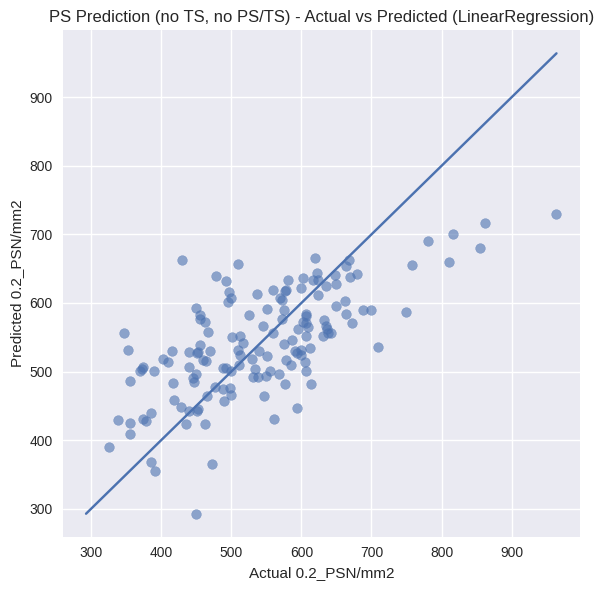

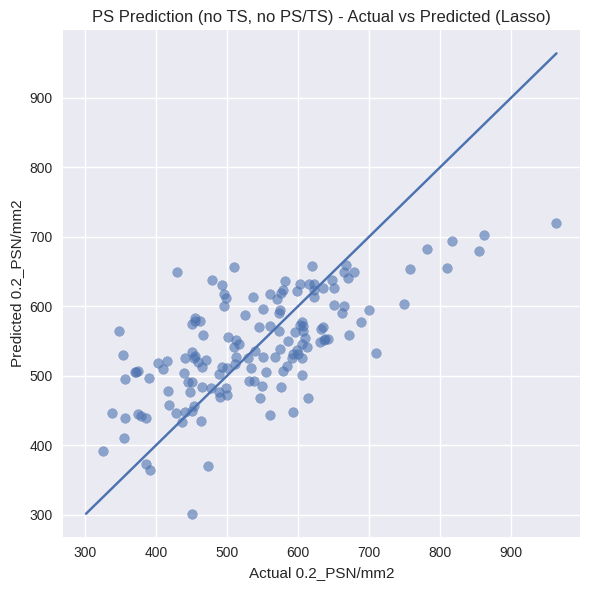

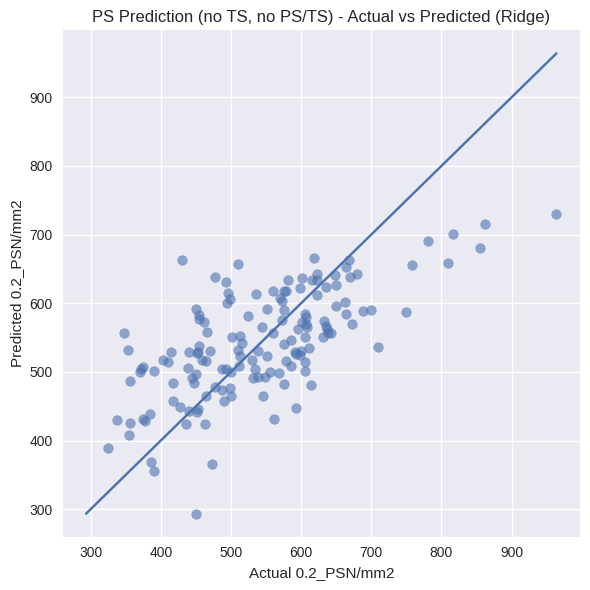

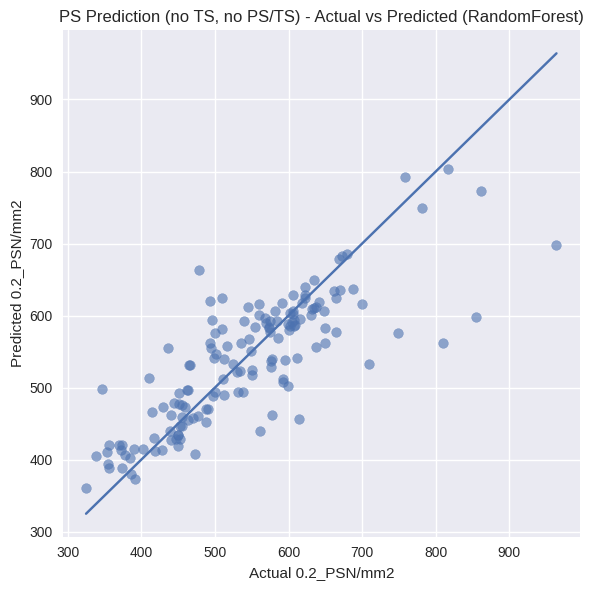

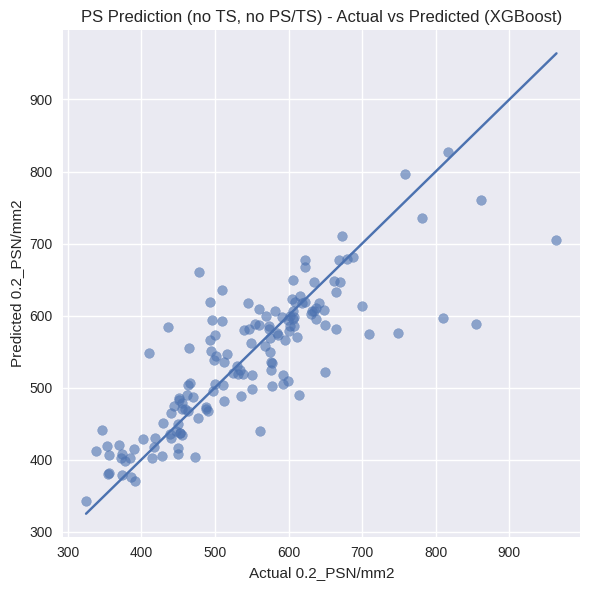

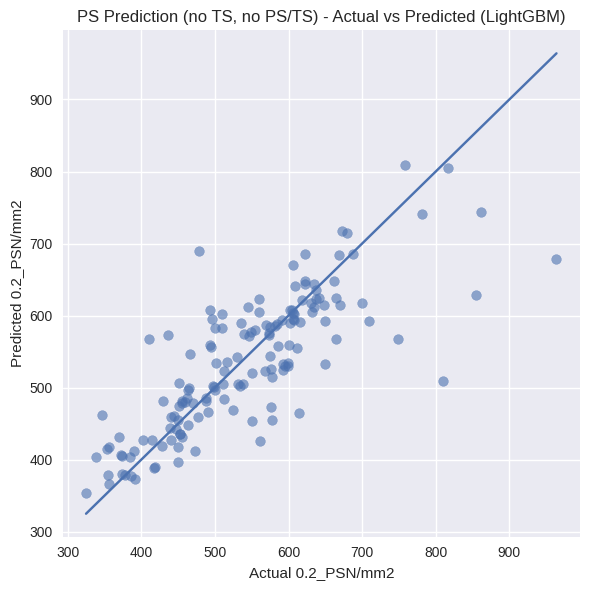

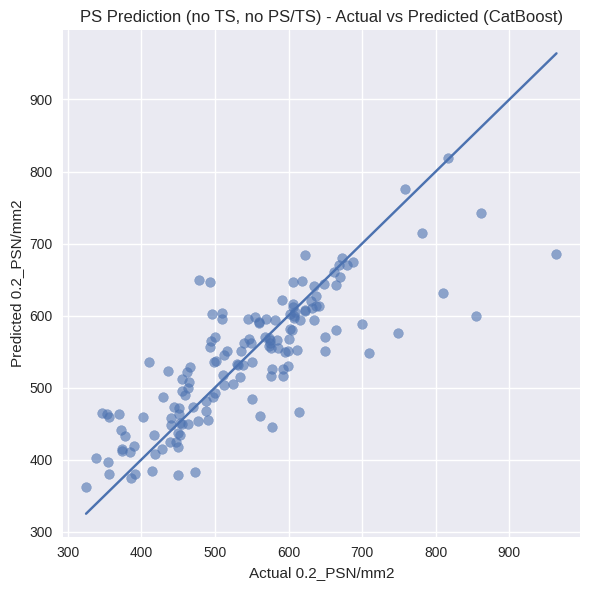

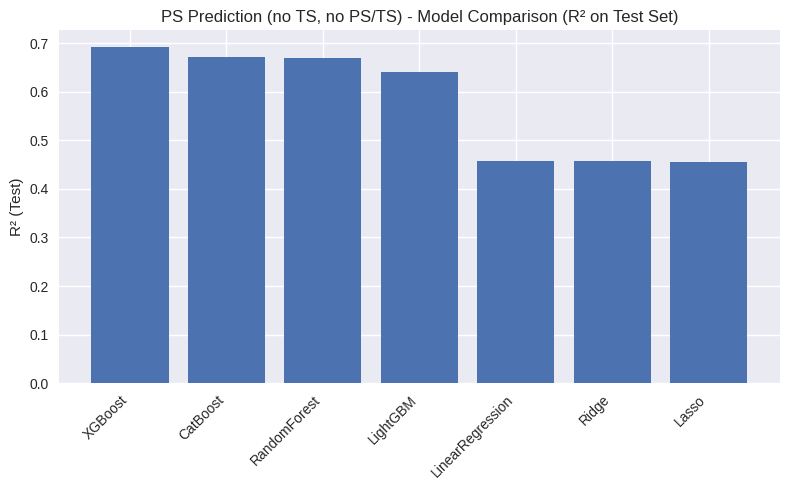


Starting GridSearchCV for Lasso (PS Prediction (no TS, no PS/TS))...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


Best Lasso params: {'model__alpha': 1.0}
Best Lasso CV R2: 0.49105670393852935
Test R2 (Lasso tuned): 0.45455161736284744
Test MAE (Lasso tuned): 67.31761603626009

Starting GridSearchCV for RandomForest (PS Prediction (no TS, no PS/TS))...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF CV R2: 0.7694589687724691
Test R2 (RF tuned): 0.6698391146892226
Test MAE (RF tuned): 44.69163567386369

Starting GridSearchCV for XGBoost (PS Prediction (no TS, no PS/TS))...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


Best XGBoost params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best XGBoost CV R2: 0.7823616982863748
Test R2 (XGB tuned): 0.6797360274494489
Test MAE (XGB tuned): 43.026341029575896

Starting GridSearchCV for LightGBM (PS Prediction (no TS, no PS/TS))...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 586, number of used features: 26
[LightGBM] [Info] Start training from score 531.556314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best LightGBM params: {'model__learning_rate': 0.03, 'model__max_depth': 10, 'model__n_estimators': 400, 'model__num_leaves': 31}
Best LightGBM CV R2: 0.7685943699237472
Test R2 (LGB tuned): 0.663042466996429
Test MAE (LGB tuned): 45.43222420552591

Starting GridSearchCV for CatBoost (PS Prediction (no TS, no PS/TS))...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (586). n_quantiles is set to n_samples.
  warnings.warn(


Best CatBoost params: {'model__depth': 8, 'model__iterations': 200, 'model__learning_rate': 0.1}
Best CatBoost CV R2: 0.7765583636493752
Test R2 (Cat tuned): 0.6608862606114347
Test MAE (Cat tuned): 44.125489894913805

=== PS Prediction (no TS, no PS/TS) - Tuned Model Performance (Test Set) ===
                                               Model        R2        MAE
2  PS Prediction (no TS, no PS/TS) - XGBoost (tuned)  0.679736  43.026341
1  PS Prediction (no TS, no PS/TS) - RandomForest...  0.669839  44.691636
3  PS Prediction (no TS, no PS/TS) - LightGBM (tu...  0.663042  45.432224
4  PS Prediction (no TS, no PS/TS) - CatBoost (tu...  0.660886  44.125490
0    PS Prediction (no TS, no PS/TS) - Lasso (tuned)  0.454552  67.317616

=== PS Prediction (no TS, no PS/TS) - Top 20 Features by Importance (RandomForest tuned) ===
                      Feature  Importance
0                           C    0.246715
16                        CEV    0.157150
22                      El.Ag    0.12062

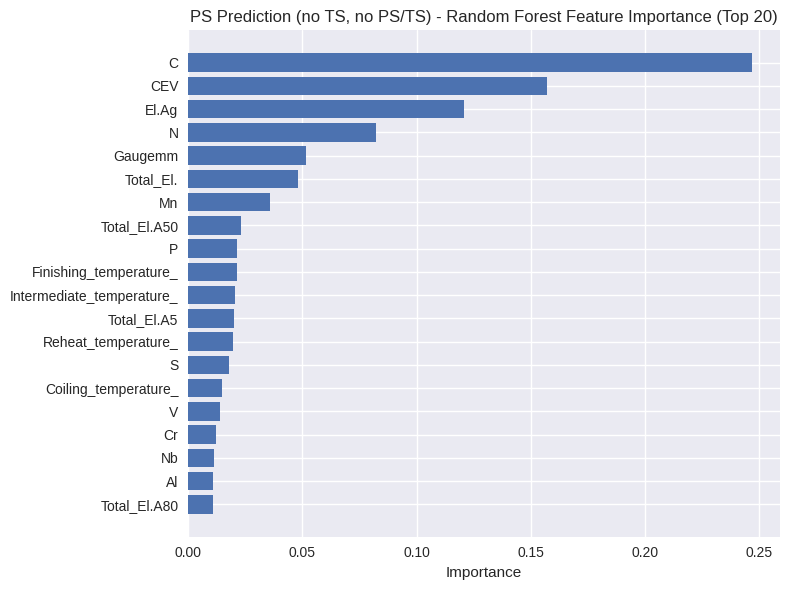

In [ ]:
# ============================================
# 5. Run experiment for PS (i: predict PS without TS and PS/TS)
# ============================================
ps_results = run_full_experiment(
    df=df,
    target_col=ps_col_name,
    exclude_cols=[ts_col_name, ratio_col_name],
    title_prefix="PS Prediction (no TS, no PS/TS)"
)



TS Prediction (no PS, no PS/TS) : Target = TSN/mm2
Excluding features: ['0.2_PSN/mm2', 'PS/TS']

X shape: (916, 27)
y shape: (916,)
X_train shape: (732, 27)
X_test shape: (184, 27)

Training base model: LinearRegression


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


LinearRegression - R2: 0.5595, MAE: 60.1055

Training base model: Lasso
Lasso - R2: 0.5720, MAE: 58.9702

Training base model: Ridge


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


Ridge - R2: 0.5600, MAE: 60.0557

Training base model: RandomForest
RandomForest - R2: 0.7947, MAE: 34.3624

Training base model: XGBoost


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


XGBoost - R2: 0.8343, MAE: 31.9031

Training base model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 27
[LightGBM] [Info] Start training from score 773.987705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


LightGBM - R2: 0.8260, MAE: 32.8140

Training base model: CatBoost
CatBoost - R2: 0.7921, MAE: 36.4607

=== TS Prediction (no PS, no PS/TS) - Base Model Performance (Test Set) ===
              Model        R2        MAE
4           XGBoost  0.834251  31.903055
5          LightGBM  0.826009  32.814035
3      RandomForest  0.794680  34.362401
6          CatBoost  0.792138  36.460715
1             Lasso  0.572004  58.970151
2             Ridge  0.560023  60.055712
0  LinearRegression  0.559475  60.105516


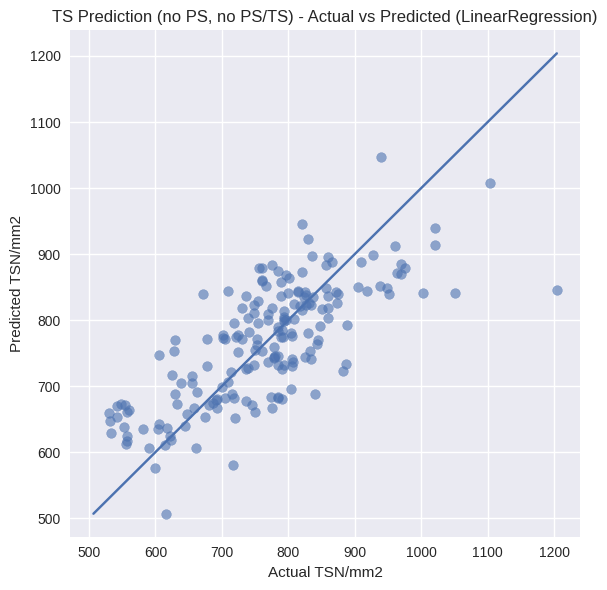

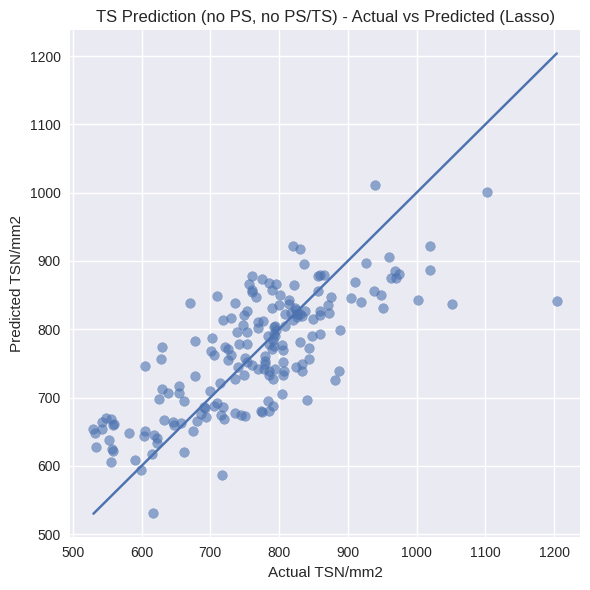

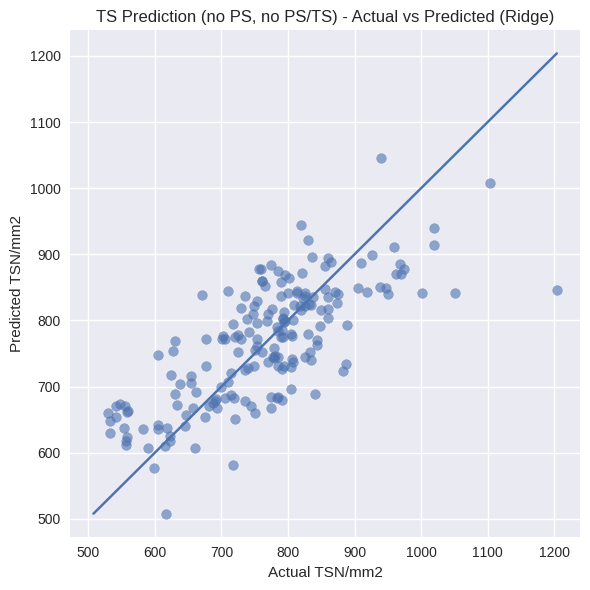

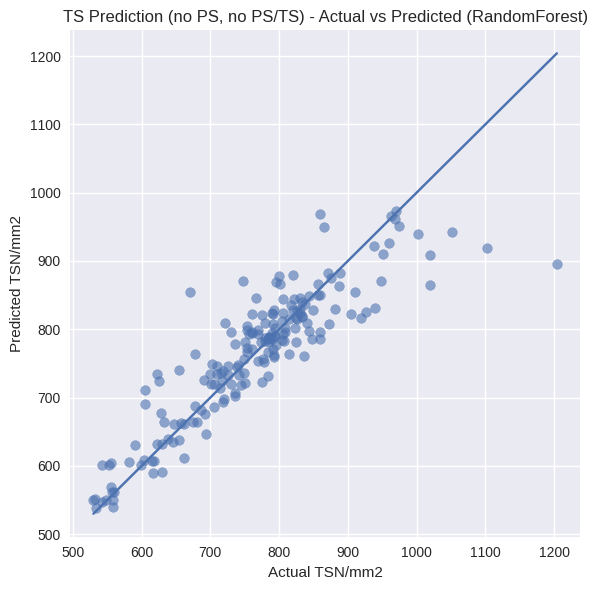

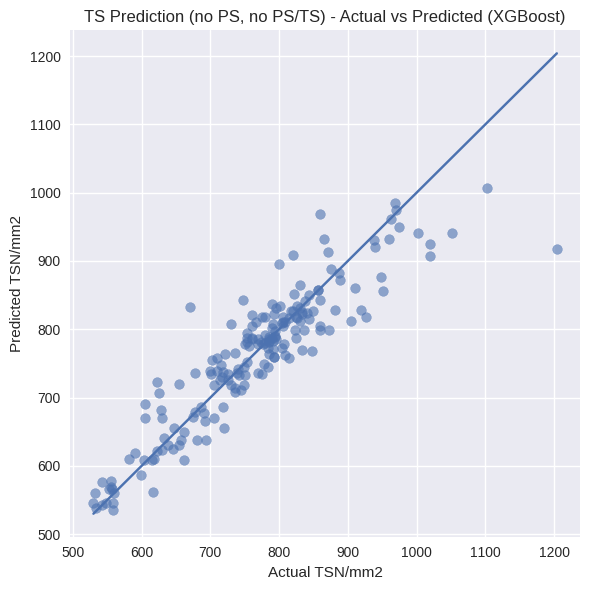

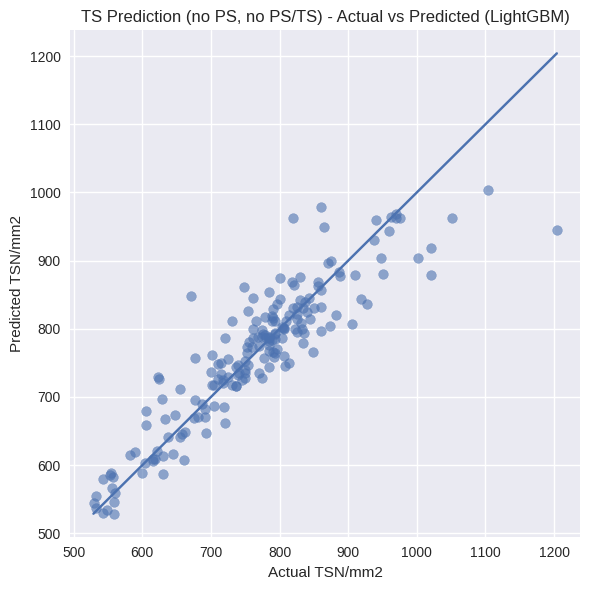

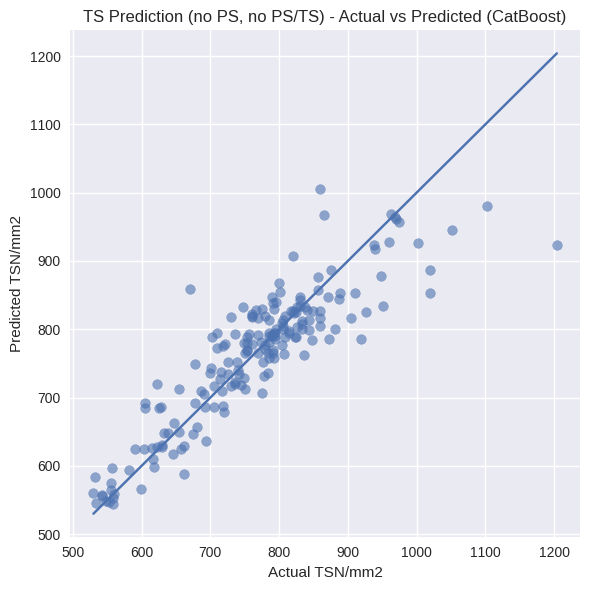

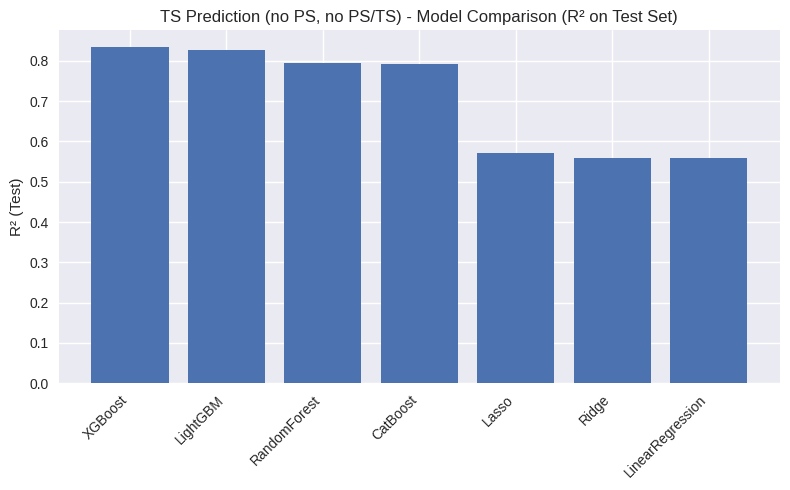


Starting GridSearchCV for Lasso (TS Prediction (no PS, no PS/TS))...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


Best Lasso params: {'model__alpha': 1.0}
Best Lasso CV R2: 0.5591457881767568
Test R2 (Lasso tuned): 0.5720039213346999
Test MAE (Lasso tuned): 58.97015142848752

Starting GridSearchCV for RandomForest (TS Prediction (no PS, no PS/TS))...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


Best RF params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best RF CV R2: 0.7785356267095336
Test R2 (RF tuned): 0.7962096530133739
Test MAE (RF tuned): 34.01999563276397

Starting GridSearchCV for XGBoost (TS Prediction (no PS, no PS/TS))...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


Best XGBoost params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.03, 'model__max_depth': 6, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best XGBoost CV R2: 0.7994715757207491
Test R2 (XGB tuned): 0.8279332749306771
Test MAE (XGB tuned): 32.22688890540081

Starting GridSearchCV for LightGBM (TS Prediction (no PS, no PS/TS))...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 27
[LightGBM] [Info] Start training from score 773.987705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (732). n_quantiles is set to n_samples.
  warnings.warn(


Best CatBoost params: {'model__depth': 6, 'model__iterations': 400, 'model__learning_rate': 0.1}
Best CatBoost CV R2: 0.7792022080451544
Test R2 (Cat tuned): 0.8146825259137301
Test MAE (Cat tuned): 34.30992919930045

=== TS Prediction (no PS, no PS/TS) - Tuned Model Performance (Test Set) ===
                                               Model        R2        MAE
2  TS Prediction (no PS, no PS/TS) - XGBoost (tuned)  0.827933  32.226889
3  TS Prediction (no PS, no PS/TS) - LightGBM (tu...  0.817210  33.834953
4  TS Prediction (no PS, no PS/TS) - CatBoost (tu...  0.814683  34.309929
1  TS Prediction (no PS, no PS/TS) - RandomForest...  0.796210  34.019996
0    TS Prediction (no PS, no PS/TS) - Lasso (tuned)  0.572004  58.970151

=== TS Prediction (no PS, no PS/TS) - Top 20 Features by Importance (RandomForest tuned) ===
                 Feature  Importance
26             Total_El.    0.264255
0                      C    0.166744
16                   CEV    0.099633
20  Coiling_tempera

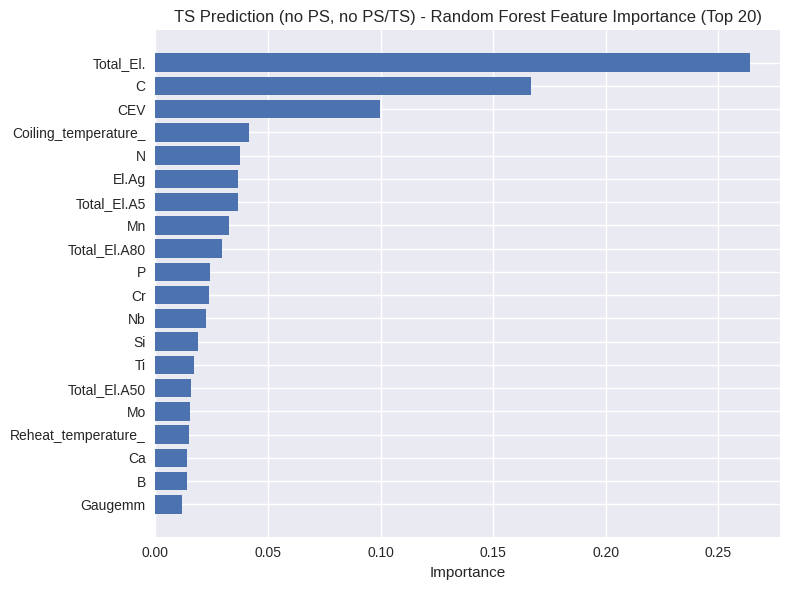

In [ ]:
# ============================================
# 6. Run experiment for TS (ii: predict TS without PS and PS/TS)
# ============================================
ts_results = run_full_experiment(
    df=df,
    target_col=ts_col_name,
    exclude_cols=[ps_col_name, ratio_col_name],
    title_prefix="TS Prediction (no PS, no PS/TS)"
)